In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import clear_output

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 64, 3, padding=1)  # [1024, 512]
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.norm1 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(1, 64, 3, padding=1)
        self.conv4 = nn.Conv1d(64, 128, 3, padding=1)
        self.norm2 = nn.BatchNorm1d(128)

        self.ll = nn.LeakyReLU()

        self.fc1 = nn.Linear(615, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.norm3 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 128)
        self.norm4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 8)

        # Self-attention layer
        # self.attention = nn.MultiheadAttention(
        #     embed_dim=2048, num_heads=10, batch_first=True
        # )

    def forward(self, x):
        xsm, params, intensities = x
        xsm_processed = torch.mean(
            self.norm1(self.conv2(self.ll(self.conv1(xsm.unsqueeze(1))))), dim=1
        )
        inten_processed = torch.mean(
            self.norm2(self.conv4(self.ll(self.conv3(intensities.unsqueeze(1))))), dim=1
        )

        y = self.ll(
            self.fc1(torch.cat((xsm_processed, params, inten_processed), dim=1))
        )
        # output = self.attention(y, y, y)[0]
        y = self.ll(self.norm3(self.fc2(y)))
        y = self.ll(self.fc3(y))
        y = self.ll(self.norm4(self.fc4(y)))
        y = self.ll(self.fc5(y))

        return F.softmax(y, dim=1)


model = Model()
model = model.to("mps")

In [10]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, files_path):
        self.path = files_path

    def __len__(self):
        return len(os.listdir(self.path)) // 3

    def __getitem__(self, idx):
        info_file = open(f"{self.path}/init_info_{idx}.txt", "r")
        params = [line.strip() for line in info_file.readlines()]
        info_file.close()
        intensities_data = pd.read_csv(
            f"{self.path}/intensities_{idx}.csv", header=None
        )[1]
        int_mean = np.mean(intensities_data)
        intensities_noise = np.random.normal(
            0, 0.07 * intensities_data, len(intensities_data)
        )
        relwts = np.fromfile(params[0])
        xsm_data = pd.read_csv(params[1], header=None, sep=" ")[2]
        mag = np.mean(xsm_data)
        xsm_noise = np.random.normal(0, 0.07 * mag, len(xsm_data))
        params = torch.tensor(
            [float(param) for param in params[2:]], dtype=torch.float32
        )
        input_data = (
            torch.tensor(xsm_data, dtype=torch.float32),
            params,
            torch.tensor(intensities_data, dtype=torch.float32),
        )

        target = torch.tensor(relwts, dtype=torch.float32)

        return input_data, target

In [11]:
from torch.utils.data import DataLoader

train_file = "./train_gen_data"
test_file = "./test_gen_data"
train_dl = DataLoader(CustomDataset(train_file), batch_size=1024, shuffle=True)
test_dl = DataLoader(CustomDataset(test_file), batch_size=1024, shuffle=True)

# kld = [0]
# mse = [0]
# kldv = [0]
# msev = [0]

In [ ]:
kld = [0]
mse = [0]
kldv = [0]
msev = [0]

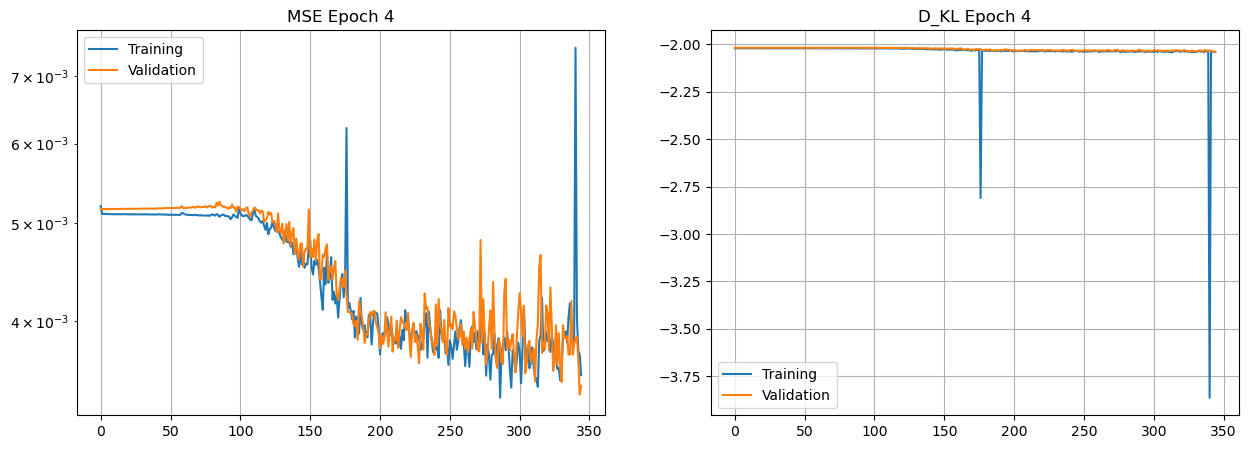

KeyboardInterrupt: 

In [12]:
epochs = 1000

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    cnts = 0
    for input, target in train_dl:
        input = [item.to("mps") for item in input]
        target = target.to("mps")
        output = model(input)
        kl_div_loss = F.kl_div(output, target, reduction="batchmean")
        mse_loss = F.mse_loss(output, target)
        loss = 0.1 * kl_div_loss + 0.9 * mse_loss
        loss.backward()
        kld[-1] += kl_div_loss.item() * output.shape[0]
        mse[-1] += mse_loss.item() * output.shape[0]
        cnts += output.shape[0]
        optimizer.step()
        optimizer.zero_grad()
    kld[-1] /= cnts
    mse[-1] /= cnts

    # validation
    cnts = 0
    for input, target in test_dl:
        input = [item.to("mps") for item in input]
        target = target.to("mps")
        output = model(input)
        kl_div_loss = F.kl_div(output, target, reduction="batchmean")
        mse_loss = F.mse_loss(output, target)
        msev[-1] += mse_loss.item() * output.shape[0]
        kldv[-1] += kl_div_loss.item() * output.shape[0]
        cnts += output.shape[0]
    msev[-1] /= cnts
    kldv[-1] /= cnts

    clear_output()
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"MSE Epoch {epoch}")
    plt.plot(mse, label="Training")
    plt.plot(msev, label="Validation")
    plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title(f"D_KL Epoch {epoch}")
    plt.plot(kld, label="Training")
    plt.plot(kldv, label="Validation")
    plt.legend()
    plt.grid()
    plt.show(block=False)
    kld.append(0)
    mse.append(0)
    kldv.append(0)
    msev.append(0)

In [ ]:
np.array([mse, msev, kld, kldv])[:, 0]
np.array([mse, msev, kld, kldv])[:, -2]

array([ 0.00353244,  0.00344785, -2.04129449, -2.0392509 ])

In [18]:
msev[345]

0

In [24]:
rmse = np.sqrt(0.00344785)
rmse

np.float64(0.05871839575465256)